# Running QAOA on IQM Garnet with Amazon Braket

This notebook demonstrates how to run the Quantum Approximate Optimization Algorithm (QAOA) on the IQM Garnet device using Amazon Braket. We will use the `braket` SDK to construct the QAOA circuit and submit it to Garnet.

First, we start off by installing the required dependencies.

In [ ]:
!pip install networkx
!pip install scipy
!pip install amazon-braket-sdk

And continue by importing the corresponding libraries.

In [ ]:
import os
import networkx as nx
from scipy.optimize import minimize
from braket.aws import AwsDevice, DirectReservation
from braket.circuits import Circuit, FreeParameter
from braket.devices import Devices, LocalSimulator

In order to set up a device with Braket you need to specify your region (`eu-north-1`) and the ARN (Amazon Resource Name) of the device you want to use. You can find the ARN of any IQM device in the Amazon Braket console.

In [ ]:
GARNET_ARN = 'arn:aws:braket:eu-north-1' # if you have a reservation, change your ARN accordingly
AWS_REGION = 'eu-north-1'

os.environ["AWS_REGION"] = AWS_REGION
device = AwsDevice(Devices.IQM.Garnet)

As sometimes you want to switch between different devices, we will define a function that sets up the device for us.

Note that SV1 is an alternative to the local simulator provided by Amazon Braket.

In [ ]:
def set_backend(device_name):
    if device_name == 'localsim':
        backend = LocalSimulator()
    elif device_name == 'sim':
        os.environ["AWS_REGION"] = "us-west-1"
        backend = AwsDevice(Devices.Amazon.SV1)
    elif device_name == 'garnet':
        backend = AwsDevice(Devices.IQM.Garnet)
    else:
        raise AttributeError('device not found')
    return backend


## Defining the problem and the QAOA circuit

We will use the `networkx` package to create a random graph.

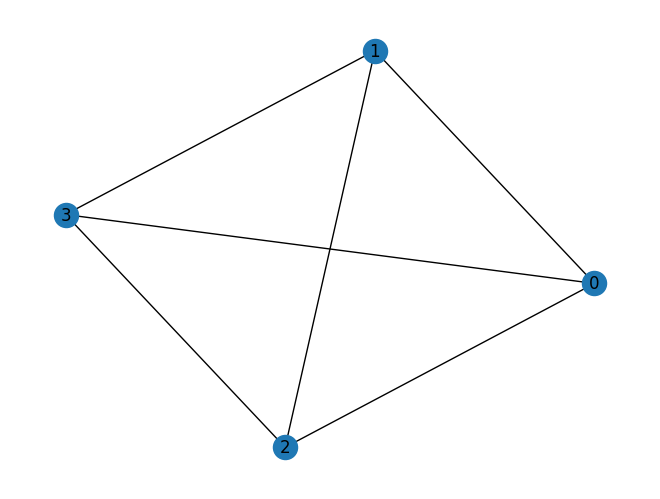

In [3]:
N_VERTICES = 4

my_graph = nx.random_regular_graph(d=3, n=N_VERTICES, seed=999)
pos = nx.spring_layout(my_graph, seed=444)
nx.draw(my_graph, with_labels=True, pos=pos)

## Defining the QAOA circuit for IQM Garnet using Amazon Braket

At the heart of the Quantum Approximate Optimization Algorithm (QAOA) is a parametrized quantum circuit designed to tackle complex optimization problems, like the Max Cut problem. The QAOA circuit is designed to efficiently explore the solution space of a given problem. It is composed of a series of alternating layers of single-qubit rotations and two-qubit interactions. By adjusting the parameters in the circuit, QAOA aims to find the optimal configuration that maximizes or minimizes a specific objective function, such as the MaxCut value in a given graph.

QAOA operates by encoding the problem into a **problem hamiltonian** whose ground state represents the optimal solution. The dynamics of the problem hamiltonian are encoded in a quantum computer by a circuit representing the **problem unitary**. Correspondingly, a circuit representing the so-called **mixer unitary** is used to explore more possible solutions to the problem. By alternating between the application of the problem unitary and the mixer unitary, QAOA evolves the quantum system toward the ground state of the problem Hamiltonian, which corresponds to the optimal solution of the combinatorial problem. 


In order to find the best parameters $\gamma$ and $\beta$, we need to have a way that measures how "good" a solution is. This is done with the cost function. It maps each possible solution (typically a bitstring like `0100`) to a real number, typically representing the cost or energy associated with that solution. Lower values of the cost function correspond to more optimal or favorable solutions.

An easy way to do this for MaxCut is to count how many edges we cut. The more edges the better. As we want to have the optimal solution corresponding to the minimal cost, we can just multiply the number of cuts with -1, so the optimal solution maps to the lowest number.


In [11]:
NUM_SHOTS = 10
PARAM_NAMES = [
    'theta',
    'gamma',
    'theta2',
    'gamma2'
]


def transform_to_superposition_state(circuit):
    """
    Adds a Hadamard gate for each qubit at the start of the circuit.
    """
    return circuit.h(range(N_VERTICES))


def add_problem_circuit(circuit, graph, parameter):
    """
    Creates a problem circuit that is part of the QAOA ansatz.
    """
    for pair in list(graph.edges()):  # pairs of nodes
        circuit.zz(pair[0], pair[1], 2 * parameter)
    return circuit


def add_mixing_circuit(circuit, parameter):
    """
    Evolve the quantum state
    """
    return circuit.rx(range(N_VERTICES), parameter)


def cost_function(graph, solution):
    """
    Compute the count of all edges of graph that are cut given a possible solution
    """
    solution_reverse = solution[::-1]
    cut = 0
    for i, j in list(graph.edges()):
        if solution_reverse[i] != solution_reverse[j]:
            cut += 1
    return -1 * cut


def compute_expectation_value(graph, counts): 
    """
    Computes expectation value based on measurement results
    """
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = cost_function(graph, bitstring)
        avg += obj * count
        sum_count += count
    return avg/sum_count


def create_objective_function(graph, circuit, backend):
    """
    Creates a function that maps the parameters to the parametrized circuit, 
    runs it and computes the expectation value
    """
    def objective_function(params):
        task = backend.run(
            circuit,
            inputs={
                "theta": params[0], "gamma": params[1],
                "theta2": params[2], "gamma2": params[3]
            },
            shots=NUM_SHOTS
        )
        result = task.result()
        counts = result.measurement_counts
        print(counts)
        return compute_expectation_value(graph, counts)
    return objective_function


theta_parameter = FreeParameter('theta')
gamma_parameter = FreeParameter('gamma')
theta2_parameter = FreeParameter('theta2')
gamma2_parameter = FreeParameter('gamma2')

test_circuit = Circuit()
transform_to_superposition_state(test_circuit)
add_problem_circuit(test_circuit, my_graph, theta_parameter)
add_mixing_circuit(test_circuit, gamma_parameter)
add_problem_circuit(test_circuit, my_graph, theta2_parameter)
add_mixing_circuit(test_circuit, gamma2_parameter)

expectation = create_objective_function(my_graph, test_circuit, device)
result = minimize(
    expectation,
    [1.0, -1.0, 1.0, -1.0],
    method='COBYLA',
    options={'maxiter': 20}
)

Counter({'1001': 2, '1010': 2, '0110': 1, '0011': 1, '1101': 1, '0101': 1, '1100': 1, '0111': 1})
Counter({'0000': 5, '1111': 3, '1001': 1, '0110': 1})
Counter({'1111': 4, '0000': 2, '1101': 1, '1010': 1, '0110': 1, '1001': 1})
Counter({'1010': 4, '1011': 1, '1001': 1, '1100': 1, '0110': 1, '1000': 1, '0111': 1})
Counter({'0100': 2, '0001': 2, '1111': 2, '0110': 1, '0011': 1, '0010': 1, '1010': 1})
Counter({'1101': 2, '0010': 2, '0100': 2, '1011': 2, '1001': 1, '1010': 1})
Counter({'0000': 2, '1111': 2, '0011': 2, '1110': 1, '1011': 1, '1010': 1, '0111': 1})
Counter({'1111': 3, '0000': 2, '1000': 2, '0110': 1, '0111': 1, '0100': 1})
Counter({'0111': 2, '1011': 2, '1010': 2, '1100': 1, '0101': 1, '0110': 1, '1111': 1})
Counter({'1001': 2, '1010': 1, '0110': 1, '1000': 1, '0001': 1, '1100': 1, '1110': 1, '0010': 1, '0000': 1})
Counter({'0011': 4, '1001': 2, '1010': 1, '0101': 1, '1111': 1, '1110': 1})
Counter({'1001': 2, '1100': 2, '1110': 2, '1000': 1, '0001': 1, '1101': 1, '0101': 1})


As this example is just to show how to run QAOA on IQM Garnet using Amazon Braket, a small shot count was used. Due to the small shot count used in the example, the results may vary. For a more accurate result, you will need to increase the number of shots. 

## Using a direct reservation window

Normally, your job will be queued and executed as soon as possible. If you do not want to wait or need exclusive time on an IQM device available via AWS Braket, you can reserve a time slot. This is useful if you want to run a longer job or if you want to run multiple jobs in a row.
You can do this using the Amazon Braket console.

In [10]:
# run the circuit in a reservation
#with DirectReservation(device, reservation_arn=GARNET_ARN):
#    task = device.run(bell, shots=100)
#    print(task.state())

'QUEUED'

In [ ]:

# Copyright 2024 IQM Quantum Computers (Max Haeberlein, Stefan Seegerer)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.